In [70]:
import gc
gc.collect()
torch.cuda.empty_cache()

## AutoEncoder

In [71]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import os
from glob import glob
import pandas as pd

In [72]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 100

In [73]:
file_path = '../dataset/origin/origin/*.jpg'
target_path = '../dataset/back2/back2/*.jpg'

file_list = glob(file_path)
target_list = glob(target_path)

In [74]:
file_list = file_list[:100000]
target_list = target_list[:100000]

In [75]:
len(target_list)

100000

### DataLoader 생성

In [76]:
data_dict = {'train_path':[], 'target_path':[]}

for i in range(len(file_list)):
    train_path = file_list[i]
    target_path = target_list[i]
    
    data_dict['train_path'].append(train_path)
    data_dict['target_path'].append(target_path)

train_df = pd.DataFrame(data_dict)

train_df.to_csv("./train.csv", mode='w')

In [77]:
df = pd.read_csv('./train.csv')

In [78]:
from torchvision import transforms

transforms_train = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor()]
)

In [79]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Classification_Dataset(Dataset):
    def __init__(self, csv, mode, transform=None):
        self.csv = csv.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0] 

    def __getitem__(self, index):   
        row = self.csv.iloc[index]                
        train_image = Image.open(row.train_path).convert('RGB') 
        target_image = Image.open(row.target_path).convert('RGB')
        
        if self.transform:
            train_image = self.transform(train_image) # 이미지에 transform 적용하기
            target_image = self.transform(target_image)

        return train_image, target_image  # 이미지와 target return하기

In [80]:
# dataset class 객체 만들기
dataset_train = Classification_Dataset(df, 'train', transform=transforms_train)

from torch.utils.data.sampler import RandomSampler
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,  num_workers=0)

In [81]:
len(train_loader)

1000

### Encoder, Decoder

In [82]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16, 32, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2, 2)
        )
        
        self.layer2 = nn.Sequential(
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(32, 32, 3, padding=1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(x.shape[0], -1)
        return out


In [83]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(32, 32, 3,2, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 16, 3, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16, 16, 3, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16, 3, 3, 2, 1,1),
                        nn.ReLU()
        )


    def forward(self,x):
        out = x.view(x.shape[0],32,56,56)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

### model 생성

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 이를 묶는 방법입니다.
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


## Train

In [87]:
pwd

'C:\\Users\\seojeongP\\Desktop\\2021\\영상처리와 딥러닝\\final_project\\code'

In [88]:
for i in tqdm(range(num_epoch)):
    for j,[train_img, target_img] in enumerate(train_loader):
      
        optimizer.zero_grad()
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        output = encoder(train_img)
        output = decoder(output) 
        
        loss = loss_func(output, target_img)
        loss.backward()
        optimizer.step()
        
    if i%10:
        print('Epoch {0} // Loss : {1}'.format(i, loss))
        
    torch.save(encoder.state_dict(), '../model/bald_Encoder.pt')
    torch.save(decoder.state_dict(), '../model/bald_Decoder.pt')

  2%|█▋                                                                                     | 2/100 [09:11<7:28:59, 274.89s/it]

Epoch 1 // Loss : 0.021665073931217194


  3%|██▌                                                                                    | 3/100 [13:46<7:24:24, 274.89s/it]

Epoch 2 // Loss : 0.02051916904747486


  4%|███▍                                                                                   | 4/100 [18:22<7:20:29, 275.31s/it]

Epoch 3 // Loss : 0.019948488101363182


  5%|████▎                                                                                  | 5/100 [23:03<7:19:05, 277.32s/it]

Epoch 4 // Loss : 0.01958448439836502


  6%|█████▏                                                                                 | 6/100 [27:41<7:14:35, 277.40s/it]

Epoch 5 // Loss : 0.020052092149853706


  7%|██████                                                                                 | 7/100 [32:17<7:09:25, 277.05s/it]

Epoch 6 // Loss : 0.01912890560925007


  8%|██████▉                                                                                | 8/100 [37:03<7:08:55, 279.73s/it]

Epoch 7 // Loss : 0.018765082582831383


  9%|███████▊                                                                               | 9/100 [41:43<7:04:28, 279.87s/it]

Epoch 8 // Loss : 0.018555618822574615


 10%|████████▌                                                                             | 10/100 [46:20<6:58:31, 279.01s/it]

Epoch 9 // Loss : 0.01834390126168728


 12%|██████████▎                                                                           | 12/100 [55:40<6:50:34, 279.94s/it]

Epoch 11 // Loss : 0.017897266894578934


 13%|██████████▉                                                                         | 13/100 [1:00:15<6:43:51, 278.52s/it]

Epoch 12 // Loss : 0.01800433173775673


 14%|███████████▊                                                                        | 14/100 [1:04:50<6:37:28, 277.31s/it]

Epoch 13 // Loss : 0.017754338681697845


 15%|████████████▌                                                                       | 15/100 [1:09:31<6:34:25, 278.42s/it]

Epoch 14 // Loss : 0.017340252175927162


 16%|█████████████▍                                                                      | 16/100 [1:14:08<6:29:30, 278.22s/it]

Epoch 15 // Loss : 0.017323624342679977


 17%|██████████████▎                                                                     | 17/100 [1:18:45<6:24:01, 277.61s/it]

Epoch 16 // Loss : 0.017121143639087677


 18%|███████████████                                                                     | 18/100 [1:23:25<6:20:38, 278.52s/it]

Epoch 17 // Loss : 0.017115449532866478


 19%|███████████████▉                                                                    | 19/100 [1:28:09<6:18:08, 280.11s/it]

Epoch 18 // Loss : 0.016920529305934906


 20%|████████████████▊                                                                   | 20/100 [1:32:53<6:15:01, 281.27s/it]

Epoch 19 // Loss : 0.016870049759745598


 22%|██████████████████▍                                                                 | 22/100 [1:42:41<6:14:52, 288.37s/it]

Epoch 21 // Loss : 0.01684120111167431


 23%|███████████████████▎                                                                | 23/100 [1:47:46<6:16:14, 293.18s/it]

Epoch 22 // Loss : 0.017848722636699677


 24%|████████████████████▏                                                               | 24/100 [1:52:50<6:15:36, 296.54s/it]

Epoch 23 // Loss : 0.01801235042512417


 25%|█████████████████████                                                               | 25/100 [1:57:37<6:06:57, 293.56s/it]

Epoch 24 // Loss : 0.017605973407626152


 26%|█████████████████████▊                                                              | 26/100 [2:02:05<5:52:37, 285.91s/it]

Epoch 25 // Loss : 0.01727103441953659


 27%|██████████████████████▋                                                             | 27/100 [2:06:18<5:35:50, 276.03s/it]

Epoch 26 // Loss : 0.017007768154144287


 28%|███████████████████████▌                                                            | 28/100 [2:10:29<5:22:30, 268.76s/it]

Epoch 27 // Loss : 0.016783488914370537


 29%|████████████████████████▎                                                           | 29/100 [2:14:43<5:12:29, 264.08s/it]

Epoch 28 // Loss : 0.016769984737038612


 30%|█████████████████████████▏                                                          | 30/100 [2:18:55<5:04:08, 260.70s/it]

Epoch 29 // Loss : 0.01976855844259262


 32%|██████████████████████████▉                                                         | 32/100 [2:27:23<4:51:19, 257.05s/it]

Epoch 31 // Loss : 0.02072756551206112


 33%|███████████████████████████▋                                                        | 33/100 [2:31:39<4:46:42, 256.75s/it]

Epoch 32 // Loss : 0.01866527460515499


 34%|████████████████████████████▌                                                       | 34/100 [2:35:51<4:41:04, 255.52s/it]

Epoch 33 // Loss : 0.017894191667437553


 35%|█████████████████████████████▍                                                      | 35/100 [2:40:04<4:35:56, 254.72s/it]

Epoch 34 // Loss : 0.017390452325344086


 36%|██████████████████████████████▏                                                     | 36/100 [2:44:17<4:31:03, 254.12s/it]

Epoch 35 // Loss : 0.01704895682632923


 37%|███████████████████████████████                                                     | 37/100 [2:48:29<4:26:17, 253.62s/it]

Epoch 36 // Loss : 0.016825959086418152


 38%|███████████████████████████████▉                                                    | 38/100 [2:52:42<4:21:52, 253.43s/it]

Epoch 37 // Loss : 0.01739310659468174


 39%|████████████████████████████████▊                                                   | 39/100 [2:56:55<4:17:22, 253.15s/it]

Epoch 38 // Loss : 0.016934560611844063


 40%|█████████████████████████████████▌                                                  | 40/100 [3:01:09<4:13:22, 253.37s/it]

Epoch 39 // Loss : 0.016721822321414948


 42%|███████████████████████████████████▎                                                | 42/100 [3:09:35<4:04:52, 253.32s/it]

Epoch 41 // Loss : 0.016446290537714958


 43%|████████████████████████████████████                                                | 43/100 [3:13:49<4:00:35, 253.25s/it]

Epoch 42 // Loss : 0.01638324186205864


 44%|████████████████████████████████████▉                                               | 44/100 [3:18:03<3:56:40, 253.57s/it]

Epoch 43 // Loss : 0.016237251460552216


 45%|█████████████████████████████████████▊                                              | 45/100 [3:22:16<3:52:16, 253.39s/it]

Epoch 44 // Loss : 0.0161205492913723


 46%|██████████████████████████████████████▋                                             | 46/100 [3:26:29<3:48:00, 253.35s/it]

Epoch 45 // Loss : 0.01604209467768669


 47%|███████████████████████████████████████▍                                            | 47/100 [3:30:43<3:43:58, 253.56s/it]

Epoch 46 // Loss : 0.01587626151740551


 48%|████████████████████████████████████████▎                                           | 48/100 [3:34:58<3:40:13, 254.10s/it]

Epoch 47 // Loss : 0.01581151969730854


 49%|█████████████████████████████████████████▏                                          | 49/100 [3:39:12<3:35:45, 253.83s/it]

Epoch 48 // Loss : 0.015695715323090553


 50%|██████████████████████████████████████████                                          | 50/100 [3:43:25<3:31:22, 253.65s/it]

Epoch 49 // Loss : 0.015563253313302994


 52%|███████████████████████████████████████████▋                                        | 52/100 [3:51:52<3:22:55, 253.65s/it]

Epoch 51 // Loss : 0.015333383344113827


 53%|████████████████████████████████████████████▌                                       | 53/100 [3:56:06<3:18:41, 253.66s/it]

Epoch 52 // Loss : 0.01572560891509056


 54%|█████████████████████████████████████████████▎                                      | 54/100 [4:00:20<3:14:27, 253.64s/it]

Epoch 53 // Loss : 0.015319288708269596


 55%|██████████████████████████████████████████████▏                                     | 55/100 [4:04:34<3:10:31, 254.03s/it]

Epoch 54 // Loss : 0.015211527235805988


 56%|███████████████████████████████████████████████                                     | 56/100 [4:08:47<3:06:01, 253.67s/it]

Epoch 55 // Loss : 0.015033627860248089


 57%|███████████████████████████████████████████████▉                                    | 57/100 [4:13:00<3:01:35, 253.38s/it]

Epoch 56 // Loss : 0.014911376871168613


 58%|████████████████████████████████████████████████▋                                   | 58/100 [4:17:14<2:57:26, 253.49s/it]

Epoch 57 // Loss : 0.014807850122451782


 59%|█████████████████████████████████████████████████▌                                  | 59/100 [4:21:27<2:53:14, 253.52s/it]

Epoch 58 // Loss : 0.01468763779848814


 60%|██████████████████████████████████████████████████▍                                 | 60/100 [4:25:41<2:49:01, 253.53s/it]

Epoch 59 // Loss : 0.014554587192833424


 62%|████████████████████████████████████████████████████                                | 62/100 [4:34:10<2:40:49, 253.94s/it]

Epoch 61 // Loss : 0.014385534450411797


 63%|████████████████████████████████████████████████████▉                               | 63/100 [4:38:25<2:36:55, 254.47s/it]

Epoch 62 // Loss : 0.014265174977481365


 64%|█████████████████████████████████████████████████████▊                              | 64/100 [4:42:39<2:32:28, 254.14s/it]

Epoch 63 // Loss : 0.014183061197400093


 65%|██████████████████████████████████████████████████████▌                             | 65/100 [4:46:52<2:28:06, 253.91s/it]

Epoch 64 // Loss : 0.014244720339775085


 66%|███████████████████████████████████████████████████████▍                            | 66/100 [4:51:06<2:23:48, 253.78s/it]

Epoch 65 // Loss : 0.01402625534683466


 67%|████████████████████████████████████████████████████████▎                           | 67/100 [4:55:20<2:19:37, 253.85s/it]

Epoch 66 // Loss : 0.014059996232390404


 68%|█████████████████████████████████████████████████████████                           | 68/100 [4:59:33<2:15:14, 253.59s/it]

Epoch 67 // Loss : 0.013763438910245895


 69%|█████████████████████████████████████████████████████████▉                          | 69/100 [5:03:46<2:10:59, 253.54s/it]

Epoch 68 // Loss : 0.01371377520263195


 70%|██████████████████████████████████████████████████████████▊                         | 70/100 [5:08:00<2:06:52, 253.76s/it]

Epoch 69 // Loss : 0.013842124491930008


 72%|████████████████████████████████████████████████████████████▍                       | 72/100 [5:16:28<1:58:25, 253.78s/it]

Epoch 71 // Loss : 0.014411288313567638


 73%|█████████████████████████████████████████████████████████████▎                      | 73/100 [5:20:41<1:54:03, 253.48s/it]

Epoch 72 // Loss : 0.013916481286287308


 74%|██████████████████████████████████████████████████████████████▏                     | 74/100 [5:24:54<1:49:43, 253.19s/it]

Epoch 73 // Loss : 0.01369777787476778


 75%|███████████████████████████████████████████████████████████████                     | 75/100 [5:29:07<1:45:28, 253.13s/it]

Epoch 74 // Loss : 0.013567150570452213


 76%|███████████████████████████████████████████████████████████████▊                    | 76/100 [5:33:19<1:41:11, 252.96s/it]

Epoch 75 // Loss : 0.013441509567201138


 77%|████████████████████████████████████████████████████████████████▋                   | 77/100 [5:37:32<1:37:00, 253.06s/it]

Epoch 76 // Loss : 0.01343571301549673


 78%|█████████████████████████████████████████████████████████████████▌                  | 78/100 [5:41:48<1:33:06, 253.91s/it]

Epoch 77 // Loss : 0.013220100663602352


 79%|██████████████████████████████████████████████████████████████████▎                 | 79/100 [5:46:00<1:28:40, 253.35s/it]

Epoch 78 // Loss : 0.013086901046335697


 80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [5:50:12<1:24:18, 252.90s/it]

Epoch 79 // Loss : 0.012921309098601341


 82%|████████████████████████████████████████████████████████████████████▉               | 82/100 [5:58:55<1:17:23, 257.96s/it]

Epoch 81 // Loss : 0.012573744170367718


 83%|█████████████████████████████████████████████████████████████████████▋              | 83/100 [6:03:23<1:13:53, 260.81s/it]

Epoch 82 // Loss : 0.01242322288453579


 84%|██████████████████████████████████████████████████████████████████████▌             | 84/100 [6:07:50<1:10:04, 262.80s/it]

Epoch 83 // Loss : 0.012364000082015991


 85%|███████████████████████████████████████████████████████████████████████▍            | 85/100 [6:12:09<1:05:23, 261.57s/it]

Epoch 84 // Loss : 0.012278304435312748


 86%|████████████████████████████████████████████████████████████████████████▏           | 86/100 [6:16:23<1:00:29, 259.24s/it]

Epoch 85 // Loss : 0.012178851291537285


 87%|██████████████████████████████████████████████████████████████████████████▊           | 87/100 [6:20:35<55:43, 257.17s/it]

Epoch 86 // Loss : 0.012115921825170517


 88%|███████████████████████████████████████████████████████████████████████████▋          | 88/100 [6:24:49<51:12, 256.08s/it]

Epoch 87 // Loss : 0.012000009417533875


 89%|████████████████████████████████████████████████████████████████████████████▌         | 89/100 [6:29:02<46:48, 255.36s/it]

Epoch 88 // Loss : 0.01190736424177885


 90%|█████████████████████████████████████████████████████████████████████████████▍        | 90/100 [6:33:15<42:25, 254.52s/it]

Epoch 89 // Loss : 0.0118339192122221


 92%|███████████████████████████████████████████████████████████████████████████████       | 92/100 [6:41:50<34:11, 256.43s/it]

Epoch 91 // Loss : 0.011738408356904984


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 93/100 [6:46:08<29:58, 256.88s/it]

Epoch 92 // Loss : 0.012788981199264526


 94%|████████████████████████████████████████████████████████████████████████████████▊     | 94/100 [6:50:23<25:36, 256.12s/it]

Epoch 93 // Loss : 0.011836347170174122


 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 95/100 [6:54:36<21:16, 255.39s/it]

Epoch 94 // Loss : 0.011712663806974888


 96%|██████████████████████████████████████████████████████████████████████████████████▌   | 96/100 [6:58:52<17:02, 255.63s/it]

Epoch 95 // Loss : 0.01166626252233982


 97%|███████████████████████████████████████████████████████████████████████████████████▍  | 97/100 [7:03:18<12:55, 258.53s/it]

Epoch 96 // Loss : 0.011628990061581135


 98%|████████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [7:07:44<08:41, 260.88s/it]

Epoch 97 // Loss : 0.011579384095966816


 99%|█████████████████████████████████████████████████████████████████████████████████████▏| 99/100 [7:12:10<04:22, 262.41s/it]

Epoch 98 // Loss : 0.01153377816081047


100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [7:16:38<00:00, 261.98s/it]

Epoch 99 // Loss : 0.011485608294606209


In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)

decoder.load_state_dict(torch.load('../model/bald_Decoder.pt'))
encoder.load_state_dict(torch.load('../model/bald_Encoder.pt'))

<All keys matched successfully>

In [96]:
from PIL import Image

test_image = Image.open('C:\\Users\\seojeongP\\Desktop\\2021\\영상처리와 딥러닝\\final_project\\dataset\\origin\\origin\\55310.jpg').convert('RGB') 
test_target = Image.open('C:\\Users\\seojeongP\\Desktop\\2021\\영상처리와 딥러닝\\final_project\\dataset\\back2\\back2\\55310.jpg').convert('RGB')

test_image = transforms_train(test_image).unsqueeze(dim=0).to(device)
test_target = transforms_train(test_target).to(device)

print(test_image.shape)
print(test_target.shape)

test_output = encoder(test_image)
test_output = decoder(test_output)

print(torch.squeeze(test_image).shape)

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [97]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


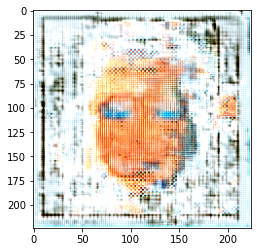

In [98]:
plt.imshow(torch.squeeze(test_output).cpu().detach().numpy().transpose(1, 2, 0))

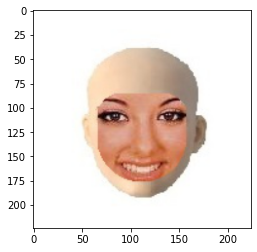

In [99]:
plt.imshow(torch.squeeze(test_target).cpu().detach().numpy().transpose(1, 2, 0))